In [8]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [9]:
# 이미지 출력, 행렬 변환을 위한 matplotlib, numpy import
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [10]:
# hyperparameters
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')
print('Using device : ', device)

Using device :  cpu


In [11]:
# Fashion MNIST
# 정답이 없기 때문에 학습 데이터셋만 사용
trainset = datasets.FashionMNIST(
    root='./.data',
    train=True, download=True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

0it [00:00, ?it/s]

100%|█████████▉| 26394624/26421880 [00:49<00:00, 506261.44it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



0it [00:00, ?it/s]


32768it [00:00, 37018.22it/s]            

0it [00:00, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



4423680it [00:08, 498158.08it/s]           

26427392it [01:00, 506261.44it/s]                              

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


In [12]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # encoder : 진행하며 특징을 3개만 남김
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        # decoder : 남은 특징을 바탕으로 원본 크기로 복원
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid() # 출력값을 0과 1로
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [15]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss() # loss

In [16]:
# 원본 이미지 시각화
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255
# 255로 나누는 이유는 모델이 인식하는 0~1 사이의 값(Sigmoid)로 만들기 위해

In [17]:
def train(model, train_loader):
    model.train()
    for step, (x, label) in enumerate(train_loader):
        # 입력과 출력이 모두 원본 이미지이다.
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device)
        label = label.to(device)
        
        encoded, decoded = model(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


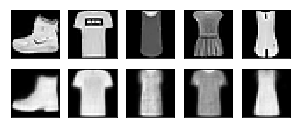

[Epoch 2]


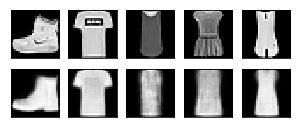

[Epoch 3]


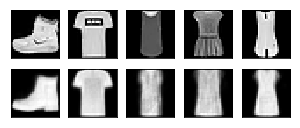

[Epoch 4]


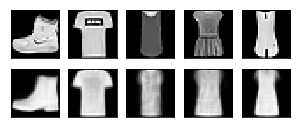

[Epoch 5]


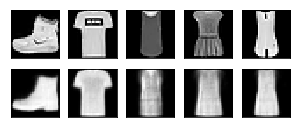

[Epoch 6]


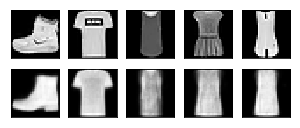

[Epoch 7]


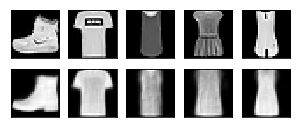

[Epoch 8]


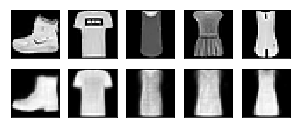

[Epoch 9]


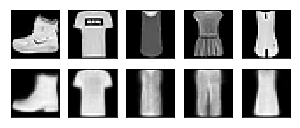

[Epoch 10]


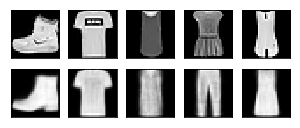

In [25]:
# 시각화
for epoch in range(1, EPOCH + 1):
    train(model, train_loader)
    
    # 디코더 시각화
    test_x = view_data.to(device)
    _, decoded_data = model(test_x)
    
    # 원본과 합성 이미지 비교
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print('[Epoch {}]'.format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i], (28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
        
    for i in range(5):
        # gpu에는 모델의 출력값이 남아 있음
        img = np.reshape(decoded_data.to('cpu').data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
        
    plt.show()

In [26]:
# 잠재 변수 확인하기
# 잠재 변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(device)
encoded_data, _ = model(test_x)
encoded_data = encoded_data.to('cpu')

In [27]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

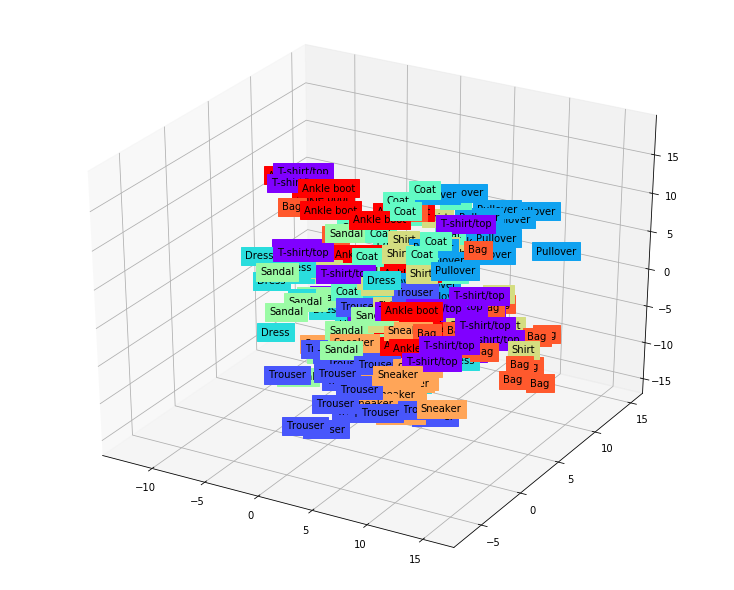

In [31]:
# 3차원 출력 공간 생성
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)
    
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

plt.show()